# Домашнее задание 2. Классификация изображений.

In this task we will need to train an image classifier. We will work with a dataset, the name of which we will not disclose. You can look at the images in the dataset yourself. It contains 200 classes and about 5 thousand pictures for each class. Classes are numbered, as it is easy to guess, from 0 to 199. You can download the dataset here [here](https://yadi.sk/d/BNR41Vu3y0c7qA).

The structure of the dataset is simple -- there are directories train/ and val/, where the training and validation data are located. In train/ and val/ there are directories corresponding to the classes of images, where the images themselves lie.
 
__Job__. You should perform two tasks

1) Achieve an accuracy **on validation of at least 0.44**. It is **forbidden** to use pre-trained models and image resizing in this task. 5 points

2) Achieve accuracy **at least 0.83** on validation. It is allowed to resize and use pretrain in this task. 5 points

Write a brief report about your experiments. What worked and what didn't work? Why did you decide to do it this way and not the other way around? Be sure to provide references to other people's code if you use it. Be sure to refer to articles / blogposts / questions on stackoverflow / youtubers' videos / courses / tips from Uncle Vasya and other additional materials if you use them. 

Your code must necessarily pass all `asserts` below.

__Use of external data for training is strictly prohibited in both assignments. It is also prohibited to train on the validation sample__.


__Grading Criteria__: The score is calculated using a simple formula: `min(10, 10 * your accuracy / 0.44)` for the first assignment and `min(10, 10 * (your accuracy - 0.5) / 0.34)` for the second assignment. Grades are rounded to the tenths using arithmetic rules.


__Tips and Directions__:
 - You will probably need to do a lot of googling about classification and how to make it work. That's fine, everyone googles. But don't forget that you need to be ready to be responsible for the rolled up code :)
 - Use augmentations. Use the `torchvision.transforms` module or the [augmentations] library(https://github.com/albumentations-team/albumentations) for this purpose.
 - You can train from scratch or filetune (depending on the job) models from `torchvision`.
 - We recommend that you first write a dataset class (or use the `ImageFolder` class) that returns images and their corresponding classes, and then trayne functions using the templates below. However, we don't force you to do this. If you're not comfortable doing so, you can write code in a style you're comfortable with. But be aware that excessive modification of the templates below will increase the number of questions to your code and increase the probability of being called for defense :)
 - Validate- Track errors as early as possible to avoid wasting time.
 - To debug your code quickly, try to train on a small part of the dataset (say, 5-10 images just to make sure that the code runs). When you realize that you can debug everything, move on to training on the whole dataset
 - Make exactly one change in the model/augmentation/optimizer for each run to understand what and how it affects the result.
 - Fix random seed.
 - Start with simple models and gradually move to complex models. Training easy models saves a lot of time.
 - Set a schedule on the learning rate. Decrease it when the validation loss stops decreasing.
 - We advise you to use a GPU. If you don't have one, use google colab. If you don't feel comfortable using it on a regular basis, write and debug all code locally on CPU and then run the already written notebook in colab. The author's solution to the problem achieves the required accuracy in colab in 15 minutes of training.
 
Good luck & have fun! :)


In [95]:

import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import math
import os
import wandb
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import os
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import lightning as L
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
from torchvision.transforms import v2
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(505505)

## Task 0 

### What can help get a 10

1. use all possible optimization methods and experiment with them.
2. Selection of learning rate. An example from the last seminar on how to do this: [How to find lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator=“gpu”, max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. data augmentation. [Documentation (useful)](https://pytorch.org/vision/main/transforms.html), and [albumentation library](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Model architecture selection. 
5. You can handwrite your own model in YourNet, or you can import an untrained mesh of a known architecture from the torchvision.models module. One way to do this is to: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`.
  * Documentation on possible models and how you can take them: [Documentation (useful)](https://pytorch.org/vision/stable/models.html)
6. Properly normalize data when creating, example [youk, but here and the whole guide from and to](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Save your progress (models) so that when something goes wrong you can start from there or just reproduce your results of the model you trained. 
 * Example of how you can with wandb here: [Save the best models in wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * A simple example is: [Save models to pytorch doc](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


### Data preprocessing

In [4]:
from PIL import Image

image_path = 'dataset/train/class_000/00001.jpg'
image = Image.open(image_path)
width, height = image.size
print(f'Original image size: {width} x {height}')


Original image size: 64 x 64


In [5]:
import torch
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ColorJitter(hue=0.05, saturation=0.05),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(20),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True ),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
transforms_val = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True ),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:

train_transform = transforms
val_transform = transforms_val

train_dataset = ImageFolder('dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/val', transform=val_transform)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4, persistent_workers=True ) 
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True) 

In [7]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Lets take a look at the pictures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


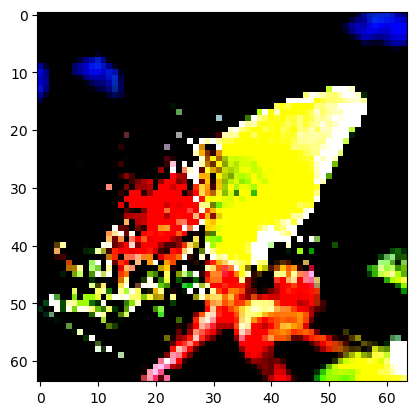

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


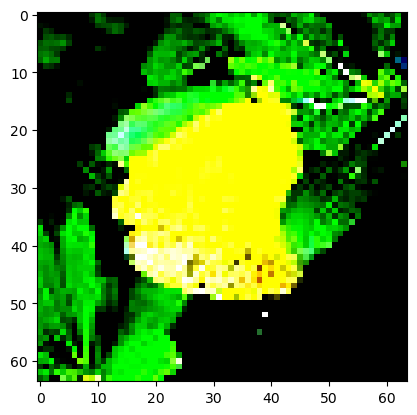

In [10]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[4].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break


## Assignment 1. 

5 points
Achieve at least 0.44 on validation. In this task it is forbidden to use pre-trained models and image resizing.


In order to beat the scor (considered below) by 2.5/5 points (i.e. half for the task) it is enough to follow a couple of simple rules of life:
1. augmentation (without it it will be very difficult)
2. Optimizers can (and should) be used with each other. However, when you test something, don't change several parameters at once - you will throw off the logic of the experiments
3. do not use full-link models or the very first convolutional models, use more modern architectures (that you met in the lectures).
4. Look at all the notebooks from past seminars and make something common out of them. Seminar notebooks will suffice over and above


## Model

In [80]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


### It is kinda a resnet but adjusted to 64x63 pictures by me

In [104]:
class BigFloppaNet(torch.nn.Module):
    def __init__(self):
        super(BigFloppaNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64,kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=True )
        self.bn1 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True )
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.drop_fc = nn.Dropout(0.5)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.layer1 =self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer( 256, 2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride = 2)
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(4096, 200)

        self.avgpool = nn.AvgPool2d(kernel_size=2, stride = 2)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, images, target=None):
        out = self.conv1(images)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.layer1(out)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.drop_fc(out)
        out = self.linear(out)
        return out

    def get_accuracy(self, dataloader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in  dataloader:
                outputs = self.forward(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return accuracy


In [105]:
class BigFloppaModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)


    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.model.parameters(), lr = self.learning_rate, weight_decay=1e-4)
        lambda_func = lambda epoch: 0.96**epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.model(x)
        loss = F.cross_entropy(output, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        acc = (torch.argmax(output, dim=1) == y).float().mean()
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)

        return loss



    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)

        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return val_loss

In [ ]:
device = torch.device('cuda:0')

In [106]:
run = wandb.init(project= 'FloppaNet1')
wandb_logger = WandbLogger(log_model='all', project='FloppaNet1')

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
train_acc_epoch,▁▃▅▆▇█
train_acc_step,▁▁▁▂▂▁▄▁▃▄▄▄▄▃▄▄▅▅▄▄▄▅▄▇▇▇▅▅▄▄█▄▅▇█▇▆▇▇▅
train_loss_epoch,█▅▃▂▂▁
train_loss_step,██▇▆▆▆▅▆▅▄▄▄▅▄▄▄▄▃▃▃▄▃▄▂▂▂▂▃▂▂▁▃▃▁▂▃▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▆▇██
val_loss,█▅▃▂▁▁
epoch,5
train_acc_epoch,0.28887
train_acc_step,0.22


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',  
    dirpath='checkpoints',  
    filename='FloppaNet1-{epoch:02d}-{val_acc:.2f}',  
    save_top_k=1,  
    mode='max'  
)

Loading the model (it was trained with the same code but on google collab)

In [ ]:
artifact = run.use_artifact('to505to505_team/uncategorized/model-9vysdrn4:v8', type='model')
artifact_dir = artifact.download()
model_path = f'{artifact_dir}/model.ckpt'
module = BigFloppaModule.load_from_checkpoint(model_path)

In [ ]:
module

BigFloppaModule(
  (model): BigFloppaNet(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (drop): Dropout(p=0.3, inplace=False)
    (drop_fc): Dropout(p=0.5, inplace=False)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [ ]:
module.learning_rate = 0.0063
trainer = pl.Trainer(accelerator="gpu", max_epochs=20, logger=wandb_logger, callbacks=[checkpoint_callback] )
trainer.fit(module, train_dataloaders=train_dataloader,val_dataloaders= val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | BigFloppaNet | 3.6 M 
---------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.391    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Link to wandb_run: https://api.wandb.ai/links/to505to505_team/4pop8p3b

### Validation

In [3]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            acc_batch = (torch.argmax(model(images), dim=1) == labels).float().mean()
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
model = BigFloppaModule.load_from_checkpoint(model_path)

accuracy = evaluate_task(model, val_dataloader)
print(f"Accuracy:  {accuracy}")

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
100%|██████████| 100/100 [00:12<00:00,  7.83it/s]

Accuracy:  0.4436998963356018


## Task 2

5 points
Achieve an accuracy on validation of at least 0.83. In this task, it is possible to resize and use pretrain.

In order to get 2.5/5 points (i.e. half for the task) you just need to follow a couple of simple life rules:
1. augmentation (without it it will be very difficult)
2. Optimizers can (and should) be used with each other. However, when you test something, don't change several parameters at once - you will throw off the logic of the experiments
3. do not use full-link models or the very first convolutional models, use more modern architectures (that you met in lectures or you can go further).
4. Try to see the quality of the original model without pre-training first, save it as a baseline. From here you will realize which layers need to be pre-trained.
5. Look at all the notebooks from past seminars and make something common out of them. Seminar notebooks will suffice

In [ ]:
transforms = v2.Compose([
     v2.RandomResizedCrop(
         size=(224, 224),
        scale=(0.7, 1.0),
        ratio=(0.8, 1.31),
        antialias=True
    ),
    v2.ColorJitter(hue=0.05, saturation=0.05),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(20),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True ),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
transforms_val = v2.Compose([
    v2.Resize(224, antialias=True),
     v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True ),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms
val_transform = transforms_val

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=2, persistent_workers=True )
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)

### Model

In [ ]:
from transformers import ViTForImageClassification, AdamW
from transformers import ViTModel, ViTFeatureExtractor

In [ ]:
class EmbedFloppaModel(nn.Module):
    def __init__(self,):
      super(EmbedFloppaModel, self).__init__()
      # self.flatten = nn.Flatten()
      self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=200                                                      )

      for param in self.model.parameters():
          param.requires_grad = False
      for param in self.model.classifier.parameters():
          param.requires_grad = True


    def forward(self, images):
      out = self.model(images)
      return out

Here I am using vit to get a CLS token and pul a linear layer after it

In [ ]:
class EmbedFloppaModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr = self.learning_rate, weight_decay=1e-4)
        lambda_func = lambda epoch: 0.975**epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.model(x)
        logits = output.logits
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)

        acc = (torch.argmax(logits, dim=1) == y).float().mean()
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)

        return loss


    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.model(x)
        logits = y_hat.logits

        val_loss = F.cross_entropy(logits, y)
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)

        acc = (torch.argmax(logits, dim=1) == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return val_loss

In [ ]:
device = torch.device('cuda:0')
run = wandb.init()
wandb_logger = WandbLogger(log_model='all', project='Pretrain' )
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',  
    dirpath='checkpoints', 
    filename='PretrainEff1-{epoch:02d}-{val_acc:.2f}',  
    save_top_k=1,  
    mode='max'  
)

In [ ]:
artifact = run.use_artifact('to505to505_team/uncategorized/model-39hpepx4:v2', type='model')
artifact_dir = artifact.download()
model_path = f'{artifact_dir}/model.ckpt'
module = EmbedFloppaModule.load_from_checkpoint(model_path)
module.learning_rate = 0.001

In [ ]:

trainer = pl.Trainer(accelerator="gpu", max_epochs=10, logger=wandb_logger, callbacks=[checkpoint_callback] )
trainer.fit(module, train_dataloaders=train_dataloader,val_dataloaders= val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | EmbedF

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Validation

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            acc_batch = (torch.argmax(model(images).logits, dim=1) == labels).float().mean()
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
model = module

accuracy = evaluate_task(model, val_dataloader)
print(accuracy)


100%|██████████| 625/625 [02:05<00:00,  4.98it/s]


tensor(0.8310, device='cuda:0')
